In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    
    sys.path.append(module_path)
    
os.chdir('..')

In [2]:
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules.plotting_functions import periodic_table_heatmap
from modules.function import get_elem_count,pymatgen_comp, get_number_of_components, get_comp_count_over_bins, alt_read_gfa_dataset
import networkx as nx
from matplotlib.patches import Rectangle
import seaborn as sns
from itertools import cycle
import sklearn.metrics as metrics

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
hardness_file_path = 'dataset/hardness.csv'
yield_str_file_path = 'dataset/yield_strength.csv'
phase_file_path = 'Files_from_GTDL_paper/gao_data.txt'
fig_location = 'figures'
hardness_df = pd.read_csv(hardness_file_path)
yield_str_df = pd.read_csv(yield_str_file_path)

## Dataset analysis

In [5]:
import scipy.stats as stats
[x0,dataY]=pickle.load(open(phase_file_path, 'rb'))
comps = [y.split(' ')[1] for y in x0]
phase_num = get_number_of_components(comps)

hardness_num = get_number_of_components(hardness_df['Composition'].values)

ys_num = get_number_of_components(yield_str_df['Composition'].values)
np.median(phase_num), np.median(hardness_num), stats.mode (phase_num), stats.mode(hardness_num)

(5.0,
 5.0,
 ModeResult(mode=array([5]), count=array([152])),
 ModeResult(mode=array([5]), count=array([178])))

In [6]:
np.max(phase_num), np.max(ys_num), np.max(hardness_num)

(9, 6, 7)

## Periodic table heatmaps of elements in the GFA and HEA phase dataset

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


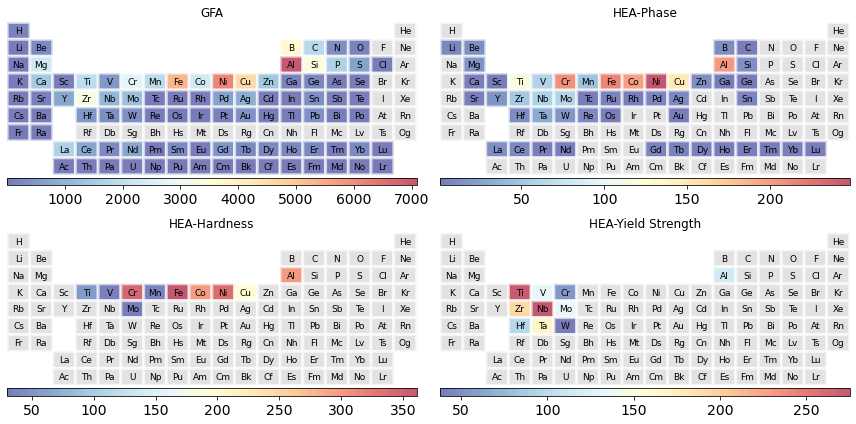

In [7]:
X, y , p = alt_read_gfa_dataset()
gfa_elem_count = get_elem_count(X)


[x0,dataY]=pickle.load(open(phase_file_path, 'rb'))
comps = [y.split(' ')[1] for y in x0]
phase_elem_count = get_elem_count(comps)

hardness_elem_count = get_elem_count(hardness_df['Composition'])

yield_elem_count = get_elem_count(yield_str_df['Composition'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

dict_list = [gfa_elem_count,phase_elem_count,hardness_elem_count,yield_elem_count]
list_names = ['GFA','HEA-Phase','HEA-Hardness','HEA-Yield Strength']

for n, ax in enumerate(axes.flatten()):
    ax = periodic_table_heatmap(dict_list[n],fig,ax,blank_color='lightgrey',edge_color='white', value_format='%.0f',
                            cmap='RdYlBu_r',symbol_fontsize=9,value_fontsize=4)
    ax.set_title(list_names[n])
plt.tight_layout()
plt.savefig('figures/element_counts.pdf', bbox_inches="tight")

## PCA components result

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


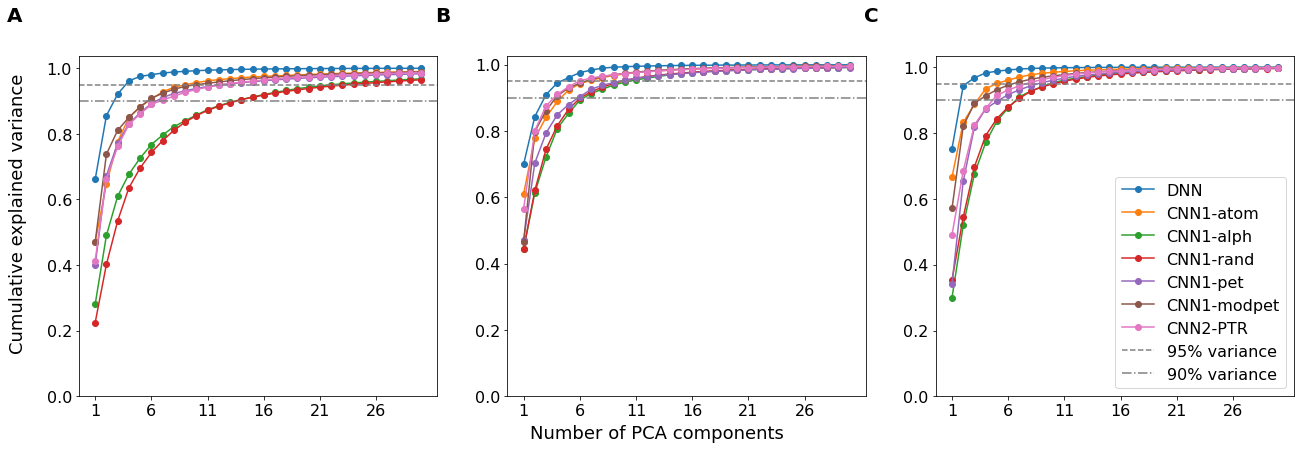

In [8]:
results_folder = 'results'
props = ['phase','hardness','ys']
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']


fig, axs = plt.subplot_mosaic("ABC", figsize=(18,6))
for n, (key, ax) in enumerate(axs.items()):
    prop = props[n]
    with open(os.path.join(results_folder,f'hea_{prop}_transfer/pca_results_{prop}.json'),'r') as fid:
        pca_dict = json.load(fid)
    for i,method in enumerate(methods):
        explained_var = np.array(pca_dict[method])
        ax.plot(np.cumsum(explained_var)[:30],marker = 'o', label = names[i])
    ax.axhline(y=0.95, color='grey', linestyle='dashed', label = '95% variance')
    ax.axhline(y=0.90, color='grey', linestyle='-.', label = '90% variance')
    ax.set_yticks(np.arange(0,1.2,0.2), fontsize = 14)
    ax.set_xticks(np.arange(0,26,5), fontsize = 14)
    ax.set_xticklabels(np.arange(1,27,5))
    ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.text(20, 0.9, '95% cut-off', color = 'grey', fontsize=14)
    #ax.set_xlabel('Number of PCA components',fontsize=14)
    #ax.set_ylabel('Cumulative explained variance', fontsize = 14)
    ax.text(-0.2, 1.1, key, transform=ax.transAxes, size=20, weight='bold')
fig.text(-0.0, 0.5, 'Cumulative explained variance', va='center', rotation='vertical', fontsize = 18)
fig.text(0.5, -0.02, 'Number of PCA components', ha='center', fontsize = 18)
plt.legend(ncol=1,loc = 'lower right', fontsize=16)
plt.tight_layout()
plt.savefig('figures/pca_components.pdf', bbox_inches="tight")

## Single task - GFA dataset

In [20]:
results_file = 'results/gfa_predict_results.json'
with open(results_file,'r') as fid:
        sup_metrics_dict = json.load(fid)

with open('results/gfa_confusion_matrix.pkl', 'rb') as fid:
    conf_matrix_dict = pickle.load(fid)
cf_df = pd.DataFrame.from_dict(conf_matrix_dict, orient='index', columns=('TN', 'FP', 'FN', 'TP'))

with open('results/gfa_roc_auc.pkl', 'rb') as fid:
    roc_scores_dict = pickle.load(fid)
cycol = cycle("bgrcmykw")


/tmp/ipykernel_3693/529155001.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation = 45, fontsize = 14)


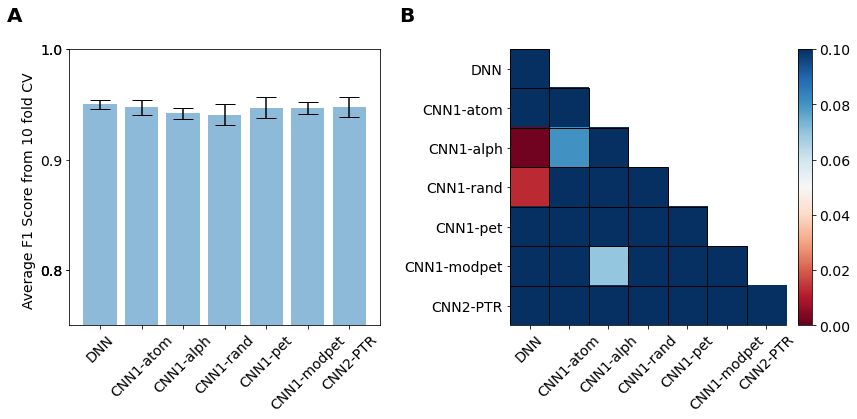

In [22]:
from itertools import combinations
from scipy.stats import ttest_ind
from matplotlib import cm as cm
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']

compare_keys = combinations(methods,2)
zero = np.eye(len(methods))
for key in compare_keys:
    a,b = key
    ind1 = np.argwhere(np.array(methods)==a)
    ind2 = np.argwhere(np.array(methods)==b)
    a_score = np.array(list(sup_metrics_dict[a].values()))[:,-1]
    b_score = np.array(list(sup_metrics_dict[b].values()))[:,-1]
    zero[ind1,ind2] = ttest_ind(a_score,b_score)[-1]

mask =  np.tri(zero.T.shape[0], k=-1)
mask =  np.tri(zero.T.shape[0], k=-1)
A = np.ma.array(zero, mask=mask).T
truth = np.where(mask == 1)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

mean_list = []
std_list = []
for i, k in enumerate(methods):
        stat_arr = np.array(list(sup_metrics_dict[k].values()))
        mean_list.append(stat_arr.mean(axis=0))
        std_list.append(stat_arr.std(axis=0))
mean_list = np.array(mean_list).T
std_list = np.array(std_list).T

fig, axs = plt.subplot_mosaic("AB", figsize=(12,6))
for n, (key, ax) in enumerate(axs.items()):
        if n == 0:
                ax.bar(methods, mean_list[-1], yerr = std_list[-1],align='center', alpha=0.5, ecolor='black', capsize=10)
                ax.set_xticklabels(names, rotation = 45, fontsize = 14)
                ax.set_yticks(np.round(np.arange(0.75,1.01,0.05),1), fontsize = 14, labels=np.round(np.arange(0.75,1.01,0.05),1))
                ax.set_ylabel('Average F1 Score from 10 fold CV ', fontsize = 14)
                ax.set(ylim=[0.75, 1])
                ax.text(-0.2, 1.1, key, transform=ax.transAxes, size=20, weight='bold')
        if n == 1:
                ax.set_xticks(np.arange(0, len(names), 1))
                ax.set_yticks(np.arange(0, len(names), 1))

                cmap = cm.get_cmap('RdBu')
                im = ax.imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
                for i in range(len(truth[0])):
                        highlight_cell(truth[1][i],truth[0][i])
                diag = [0,1,2,3,4,5]
                for k in diag:
                        highlight_cell(k,k)
                ax.set_xticklabels(names, rotation = 45, fontsize = 14)
                ax.set_yticklabels(names, fontsize = 14)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(True)
                ax.spines['left'].set_visible(False)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                for t in cb.ax.get_yticklabels():
                        t.set_fontsize(14)
                ax.text(-0.4, 1.1, key, transform=ax.transAxes, 
                size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('figures/gfa_results.pdf', bbox_inches="tight")

### Confusion matrix and ROC

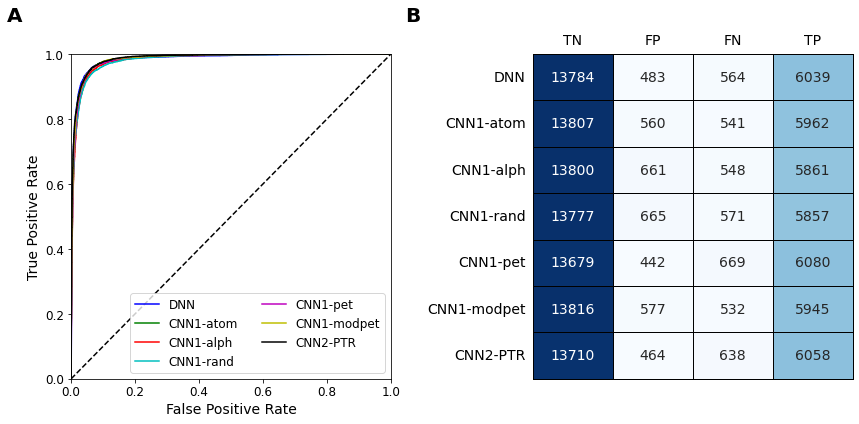

In [66]:
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
fig, axs = plt.subplot_mosaic("AB", figsize=(12,6))
cycol = cycle("bgrcmykw")
for num, (key, ax) in enumerate(axs.items()):
        if num == 0:
            for i,k in enumerate(roc_scores_dict.keys()):
                fpr = roc_scores_dict[k]['fpr']
                tpr = roc_scores_dict[k]['tpr']
                auc = metrics.auc(fpr, tpr)
                ax.plot(fpr, tpr, label =f'{names[i]}', c = next(cycol))
            ax.tick_params(labelsize = 12)
            ax.plot([0, 1], [0, 1],'k--')
            ax.legend(fontsize = 12, ncol = 2, loc = 'lower right')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_ylabel('True Positive Rate', fontsize = 14)
            ax.set_xlabel('False Positive Rate', fontsize = 14)
            ax.text(-0.2, 1.1, key, transform=ax.transAxes, size=20, weight='bold')
        if num == 1:
            ax = sns.heatmap(cf_df, annot=True, cmap='Blues',fmt='g', annot_kws={"size":14}, cbar = False,linewidths=1, linecolor='black',clip_on=False)
            ax.xaxis.tick_top() # x axis on top
            ax.xaxis.set_label_position('top')
            ax.set_yticklabels(names, fontsize = 14)
            ax.tick_params(left=False, top=False, labelsize = 14)
            ax.text(-0.4, 1.1, key, transform=ax.transAxes, size=20, weight='bold')
            
            
plt.tight_layout()
plt.savefig('figures/gfa_roc_confusion_combined.pdf', bbox_inches="tight")

## Transfer learning results

### HEA phase prediction

In [67]:
results_loc = 'results/hea_phase_transfer/'
with open(os.path.join(results_loc,'hea_phase_results.json'),'r') as fid:
    to_dump_dict = json.load(fid)

baseline_score = pd.read_csv(os.path.join(results_loc,'hea_phase_baseline.csv'), index_col = 0)
baseline = baseline_score['F1 Score'].mean()
baseline_std = baseline_score['F1 Score'].std()

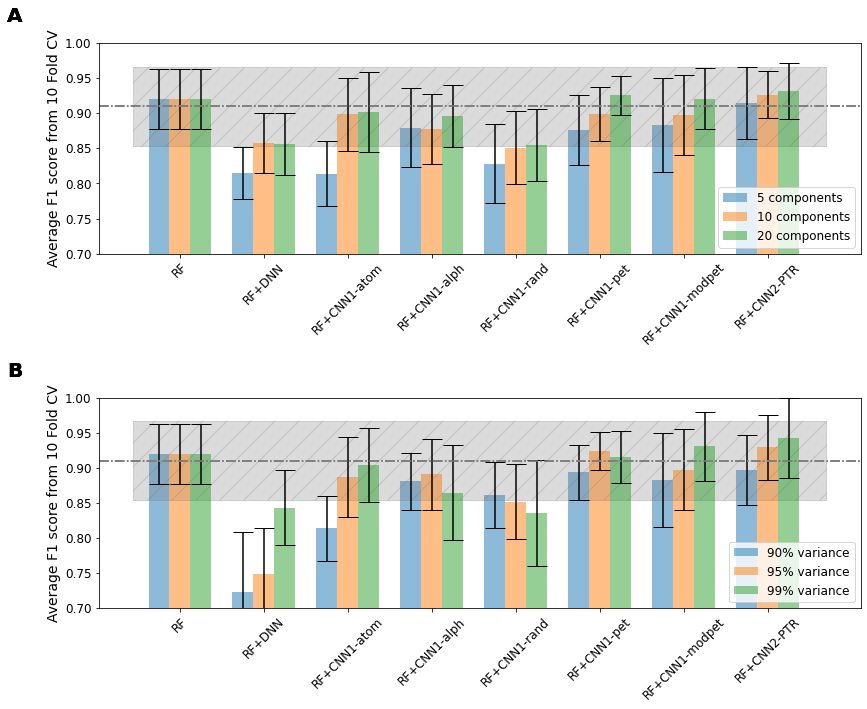

In [68]:
names = ['RF','RF+DNN','RF+CNN1-atom','RF+CNN1-alph','RF+CNN1-rand','RF+CNN1-pet','RF+CNN1-modpet','RF+CNN2-PTR']
fig,axs = plt.subplot_mosaic([["A"],["B"]], figsize=(12,10))
keys = list(to_dump_dict.keys())
barWidth = 0.25
for i,(lab, ax) in enumerate(axs.items()):
    temp_dict = to_dump_dict[keys[i]]
    for ind,k in enumerate(temp_dict.keys()):
            mean_scores = []
            std_scores = []
            spec_dict = temp_dict[k]
            for ind2,method in enumerate(spec_dict.keys()):
                mean_scores.append(np.mean(spec_dict[method]))
                std_scores.append(np.std(spec_dict[method]))
            x = np.arange(len(mean_scores))
            x_mod = ind*barWidth + x
            if keys[i] == 'fixed_comps':
                label = f'{k} components'
            else:
                label =  f'{int(float(k)*100)}% variance'
            ax.add_patch(Rectangle((0-baseline_std-barWidth, baseline-baseline_std), 8+barWidth, 2*baseline_std, hatch = '/', alpha = 0.1, color='grey'))
            ax.bar(x_mod, mean_scores, yerr = std_scores,align='center', ecolor='black', 
        capsize=10, width=barWidth, label = label, alpha=0.5)
            
            #ax[i].axhline(baseline - baseline_std, linestyle='dashed', c='grey')
            ax.axhline(baseline, linestyle='-.', c='grey')
            #ax[i].axhline(baseline + baseline_std, linestyle='dashed', c='grey')
            ax.set_xticks(np.arange(0.25,len(x)+0.25,1),labels = names, rotation=45, fontsize = 14)
            ax.set_ylabel('Average F1 score from 10 Fold CV', fontsize = 14)
            #ax[i].set_title(keys[i])
            ax.set_ylim(0.7,1)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.legend(loc = 'lower right', fontsize = 12)
            ax.text(-0.12, 1.1, lab, transform=ax.transAxes, size=20, weight='bold')
plt.tight_layout()
plt.savefig('figures/hea_phase_transfer_combined.pdf',bbox_inches="tight")

#### statisitical significance

In [69]:
with open(os.path.join(results_loc,'hea_phase_statistical_test.json'),'r') as fid:
    p_value_dict_sup = json.load(fid)

In [71]:
print(pd.DataFrame.from_dict(p_value_dict_sup['fixed_var']).round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    0.9 &   0.95 &   0.99 \\
\midrule
0 &  0.672 &  0.672 &  0.672 \\
1 &  0.000 &  0.000 &  0.016 \\
2 &  0.001 &  0.389 &  0.811 \\
3 &  0.209 &  0.448 &  0.133 \\
4 &  0.056 &  0.032 &  0.028 \\
5 &  0.466 &  0.495 &  0.818 \\
6 &  0.353 &  0.641 &  0.406 \\
7 &  0.610 &  0.427 &  0.232 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3693/1003228854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(p_value_dict_sup['fixed_var']).round(3).to_latex())


### HEA hardness prediction

In [72]:
results_loc = 'results/hea_hardness_transfer/'
with open(os.path.join(results_loc,'hea_hardness_results.json'),'r') as fid:
    hea_hardness_stat_dict = json.load(fid)


with open(os.path.join(results_loc,'hea_hardness_baseline.json'),'r') as fid:
    baseline_dict = json.load(fid)

baseline_rmse = np.mean(baseline_dict['rmse'])
baseline_rmse_std = np.std(baseline_dict['rmse'])
baseline_r = np.mean(baseline_dict['r'])
baseline_r_std = np.std(baseline_dict['r'])

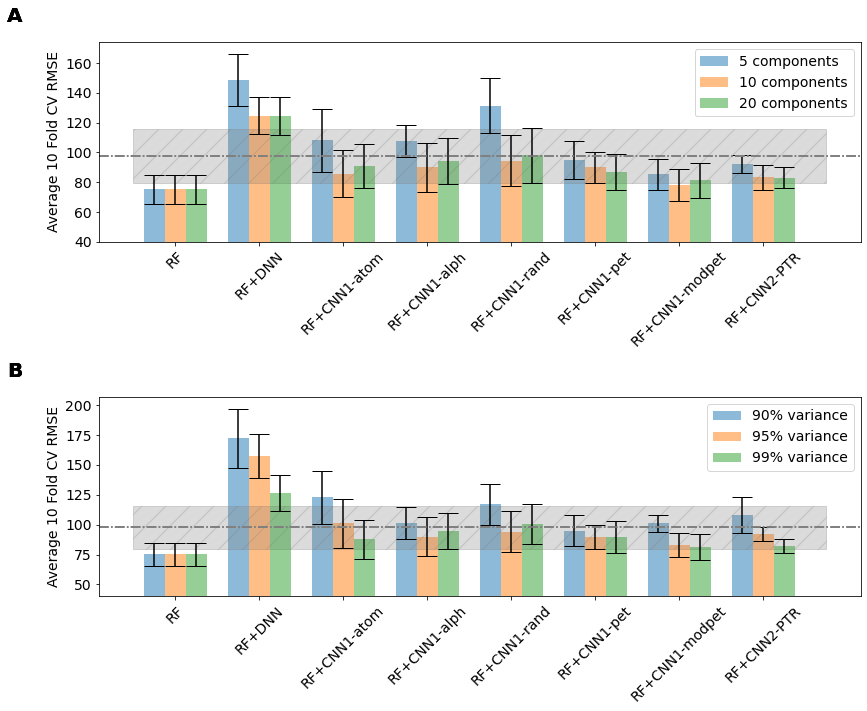

In [73]:
mini_key = ['rmse']
names = ['RF','RF+DNN','RF+CNN1-atom','RF+CNN1-alph','RF+CNN1-rand','RF+CNN1-pet','RF+CNN1-modpet','RF+CNN2-PTR']
fig,axs = plt.subplot_mosaic([["A"],["B"]], figsize=(12,10))
keys = list(hea_hardness_stat_dict.keys())
barWidth = 0.25
for i,(lab, ax) in enumerate(axs.items()):
    temp_dict = hea_hardness_stat_dict[keys[i]]
    for j in range(len(mini_key)):
        for ind,k in enumerate(temp_dict.keys()):
            mean_scores = []
            std_scores = []
            spec_dict = temp_dict[k]
            for ind2,method in enumerate(spec_dict.keys()):
                mean_scores.append(np.mean(temp_dict[k][method][mini_key[j]]))
                std_scores.append(np.std(temp_dict[k][method][mini_key[j]]))
            x = np.arange(len(mean_scores))
            x_mod = ind*barWidth + x
            if keys[i] == 'fixed_comps':
                label = f'{k} components'
            else:
                label =  f'{int(float(k)*100)}% variance'
            ax.bar(x_mod, mean_scores, yerr = std_scores,align='center', alpha=0.5, ecolor='black', 
    capsize=10, width=barWidth, label = label)
            ax.set_xticks(np.arange(0.25,len(x)+0.25,1),labels = names, rotation=45)
            #ax[j].set_title(mini_key[j].upper())
            ax.legend(loc='upper right', fontsize = 14)
            if mini_key[j] == 'rmse':
                #ax[j].axhline(baseline_rmse - baseline_rmse_std,linestyle='dashed',c='grey')
                ax.axhline(baseline_rmse,linestyle='-.',c='grey')
                #ax[j].axhline(baseline_rmse + baseline_rmse_std,linestyle='dashed',c='grey')
                ax.add_patch(Rectangle((0-barWidth, baseline_rmse-baseline_rmse_std), 8+barWidth, 2*baseline_rmse_std, hatch = '/', alpha = 0.1, color='grey'))
                ax.set_ylim(40)
                ax.tick_params(axis='both', which='major', labelsize=14)
                ax.set_ylabel('Average 10 Fold CV RMSE', fontsize = 14)
                #ax[j].set_ylim(1)
            else:
                #ax[j].axhline(baseline_r - baseline_r_std,linestyle='dashed',c='grey')
                ax.axhline(baseline_r,linestyle='-.',c='grey')
                #ax[j].axhline(baseline_r + baseline_r_std,linestyle='dashed',c='grey')
                ax.add_patch(Rectangle((0-barWidth, baseline_r-baseline_r_std), 8+barWidth, 2*baseline_r_std, hatch = '/', alpha = 0.1, color='grey'))
                ax.set_ylim(0.7,1)
                ax.tick_params(axis='both', which='major', labelsize=14)
                ax.set_ylabel('Average 10 Fold CV R', fontsize = 14)
            ax.text(-0.12, 1.1, lab, transform=ax.transAxes, size=20, weight='bold')
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig('figures/hea_hardness_transfer_combined.pdf')

#### Statistical significance

In [74]:
with open(os.path.join(results_loc,'hea_hardness_statistical_test.json'),'r') as fid:
    p_value_dict_sup = json.load(fid)

In [76]:
print(pd.DataFrame.from_dict(p_value_dict_sup['fixed_var']).round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    0.9 &   0.95 &   0.99 \\
\midrule
0 &  0.005 &  0.005 &  0.005 \\
1 &  0.000 &  0.000 &  0.002 \\
2 &  0.016 &  0.699 &  0.238 \\
3 &  0.642 &  0.364 &  0.712 \\
4 &  0.031 &  0.685 &  0.732 \\
5 &  0.716 &  0.260 &  0.286 \\
6 &  0.607 &  0.053 &  0.035 \\
7 &  0.202 &  0.389 &  0.032 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3693/1003228854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(p_value_dict_sup['fixed_var']).round(3).to_latex())


### HEA Yield strength prediction 

In [77]:
results_loc = 'results/hea_ys_transfer/'
with open(os.path.join(results_loc,'hea_ys_results.json'),'r') as fid:
    hea_ys_stat_dict = json.load(fid)


with open(os.path.join(results_loc,'hea_ys_baseline.json'),'r') as fid:
    baseline_dict = json.load(fid)

baseline_rmse = np.mean(baseline_dict['rmse'])
baseline_rmse_std = np.std(baseline_dict['rmse'])
baseline_r = np.mean(baseline_dict['r'])
baseline_r_std = np.std(baseline_dict['r'])

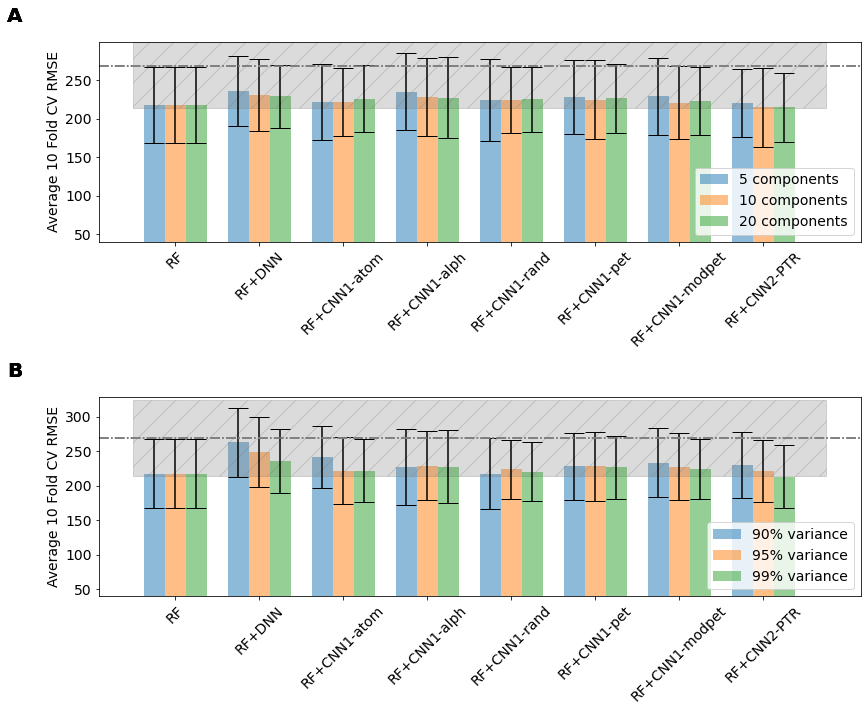

In [78]:
mini_key = ['rmse']
names = ['RF','RF+DNN','RF+CNN1-atom','RF+CNN1-alph','RF+CNN1-rand','RF+CNN1-pet','RF+CNN1-modpet','RF+CNN2-PTR']
fig,axs = plt.subplot_mosaic([["A"],["B"]], figsize=(12,10))
keys = list(hea_ys_stat_dict.keys())
barWidth = 0.25
for i,(lab, ax) in enumerate(axs.items()):
    temp_dict = hea_ys_stat_dict[keys[i]]
    for j in range(len(mini_key)):
        for ind,k in enumerate(temp_dict.keys()):
            mean_scores = []
            std_scores = []
            spec_dict = temp_dict[k]
            for ind2,method in enumerate(spec_dict.keys()):
                mean_scores.append(np.mean(temp_dict[k][method][mini_key[j]]))
                std_scores.append(np.std(temp_dict[k][method][mini_key[j]]))
            x = np.arange(len(mean_scores))
            x_mod = ind*barWidth + x
            if keys[i] == 'fixed_comps':
                label = f'{k} components'
            else:
                label =  f'{int(float(k)*100)}% variance'
            ax.bar(x_mod, mean_scores, yerr = std_scores,align='center', alpha=0.5, ecolor='black', 
    capsize=10, width=barWidth, label = label)
            ax.set_xticks(np.arange(0.25,len(x)+0.25,1),labels = names, rotation=45)
            #ax[j].set_title(mini_key[j].upper())
            ax.legend(loc='lower right', fontsize = 14)
            if mini_key[j] == 'rmse':
                #ax[j].axhline(baseline_rmse - baseline_rmse_std,linestyle='dashed',c='grey')
                ax.axhline(baseline_rmse,linestyle='-.',c='grey')
                #ax[j].axhline(baseline_rmse + baseline_rmse_std,linestyle='dashed',c='grey')
                ax.add_patch(Rectangle((0-barWidth, baseline_rmse-baseline_rmse_std), 8+barWidth, 2*baseline_rmse_std, hatch = '/', alpha = 0.1, color='grey'))
                ax.set_ylim(40)
                ax.tick_params(axis='both', which='major', labelsize=14)
                ax.set_ylabel('Average 10 Fold CV RMSE', fontsize = 14)
                #ax[j].set_ylim(1)
            else:
                #ax[j].axhline(baseline_r - baseline_r_std,linestyle='dashed',c='grey')
                ax.axhline(baseline_r,linestyle='-.',c='grey')
                #ax[j].axhline(baseline_r + baseline_r_std,linestyle='dashed',c='grey')
                ax.add_patch(Rectangle((0-barWidth, baseline_r-baseline_r_std), 8+barWidth, 2*baseline_r_std, hatch = '/', alpha = 0.1, color='grey'))
                ax.set_ylim(0.7,1)
                ax.tick_params(axis='both', which='major', labelsize=14)
                ax.set_ylabel('Average 10 Fold CV R', fontsize = 14)
            ax.text(-0.12, 1.1, lab, transform=ax.transAxes, size=20, weight='bold')
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig('figures/hea_ys_transfer_combined.pdf')

#### statistical significance

In [79]:
with open(os.path.join(results_loc,'hea_ys_statistical_test.json'),'r') as fid:
    p_value_dict_sup = json.load(fid)

In [85]:
print(pd.DataFrame.from_dict(p_value_dict_sup['fixed_var']).round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    0.9 &   0.95 &   0.99 \\
\midrule
0 &  0.052 &  0.052 &  0.052 \\
1 &  0.812 &  0.432 &  0.181 \\
2 &  0.265 &  0.072 &  0.067 \\
3 &  0.126 &  0.128 &  0.120 \\
4 &  0.056 &  0.069 &  0.051 \\
5 &  0.111 &  0.115 &  0.095 \\
6 &  0.168 &  0.109 &  0.077 \\
7 &  0.127 &  0.063 &  0.032 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3693/1003228854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(p_value_dict_sup['fixed_var']).round(3).to_latex())


## Random subsampling

### HEA Phase

In [20]:
results_loc = 'results/hea_phase_general'
with open(os.path.join(results_loc,'random_subsampling_hea_phase.json'),'r') as fid:
    results_dict = json.load(fid)

ind_dict = results_dict['fixed_inds']
var_dict = results_dict['fixed_var']

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


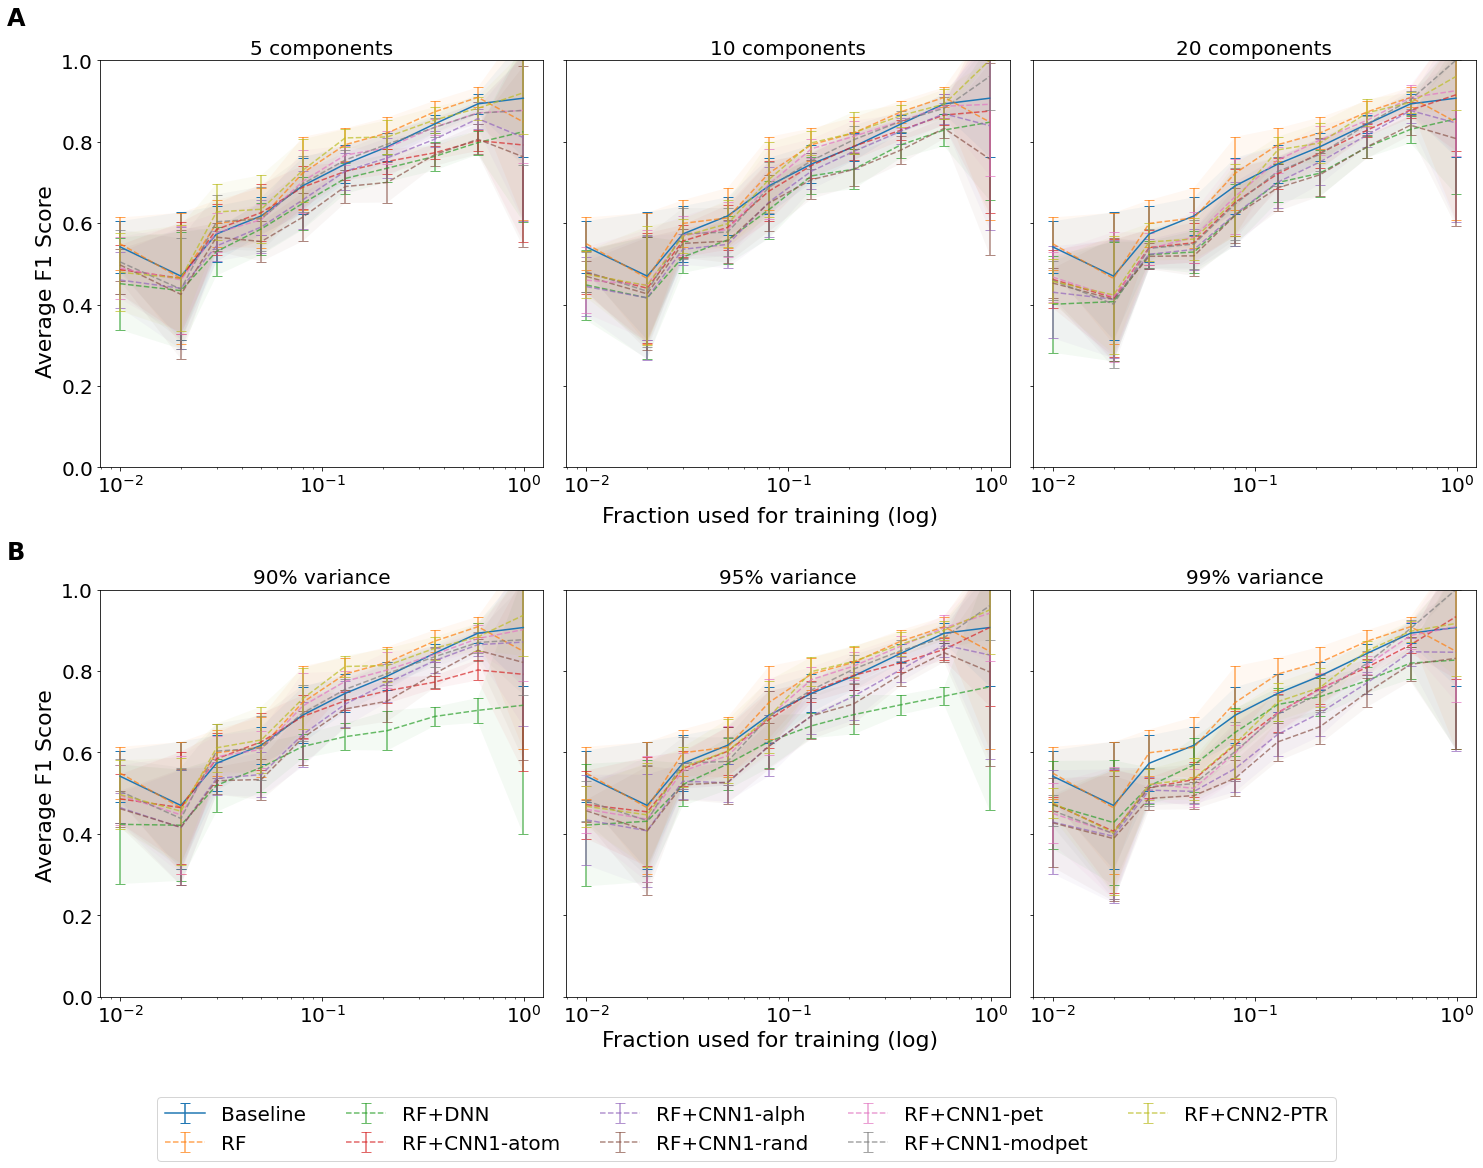

In [21]:
fig,ax  = plt.subplots(2,3,figsize= (20,14), sharex = False ,sharey = True)
ax = ax.ravel()
methods = ['Baseline','RF','RF+DNN','RF+CNN1-atom','RF+CNN1-alph','RF+CNN1-rand','RF+CNN1-pet','RF+CNN1-modpet','RF+CNN2-PTR']
ind = 0
for key in results_dict.keys():
    temp_dict = results_dict[key]
    for j,c in enumerate(temp_dict.keys()):
        method_dict = temp_dict[c]
        for k,method in enumerate(method_dict.keys()):
            random_subsampling_dict = method_dict[method]
            mean_list = []
            std_list = []
            for i in random_subsampling_dict.keys():
                mean = np.mean(random_subsampling_dict[i])
                std = np.std(random_subsampling_dict[i])
                mean_list.append(mean)
                std_list.append(std)
            mean_list = np.array(mean_list)
            std_list = np.array(std_list)
            if method != 'baseline':
                style = '--'
                alpha = 0.7
            else:
                style = '-'
                alpha = 1
            if key == 'fixed_inds':
                title = f'{c} components'
            else:
                title = f'{int(float(c)*100)}% variance'
            X = [float(x) for x in random_subsampling_dict.keys()]
            ax[ind].errorbar(X,mean_list,yerr = std_list,capsize=5,label = methods[k], linestyle = style, alpha = alpha)
            ax[ind].fill_between(X, mean_list-std_list, mean_list+std_list, alpha = 0.05, antialiased=True)
            ax[ind].set_xscale('log')
            ax[ind].set_ylim(0,1)
            ax[ind].set_title(title, fontsize = 20)
            ax[ind].tick_params(axis='both', which='major', labelsize=20)

        ind += 1

fig.text(-0.01, 0.75, 'Average F1 Score', va='center', rotation='vertical', fontsize = 22)
fig.text(-0.01, 0.25, 'Average F1 Score', va='center', rotation='vertical', fontsize = 22)
fig.text(-0.03, 1.01, 'A', va='center', size=24, weight='bold')
fig.text(-0.03, 0.48, 'B', va='center', size=24, weight='bold')
fig.text(0.5, -0.01, 'Fraction used for training (log)', ha='center', fontsize = 22)
fig.text(0.5, 0.51, 'Fraction used for training (log)', ha='center', fontsize = 22)
plt.tight_layout()
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, fontsize = 20, ncol = 5, bbox_to_anchor = (-0.1, -0.05, 1, 0))
fig.subplots_adjust(hspace=0.3)
plt.savefig('figures/hea_phase_general_combined.pdf',bbox_inches="tight")

### HEA hardness

In [22]:
results_loc = 'results/hea_hardness_general'
with open(os.path.join(results_loc,'random_subsampling_hea_hardness.json'),'r') as fid:
    results_dict = json.load(fid)

ind_dict = results_dict['fixed_inds']
var_dict = results_dict['fixed_var']

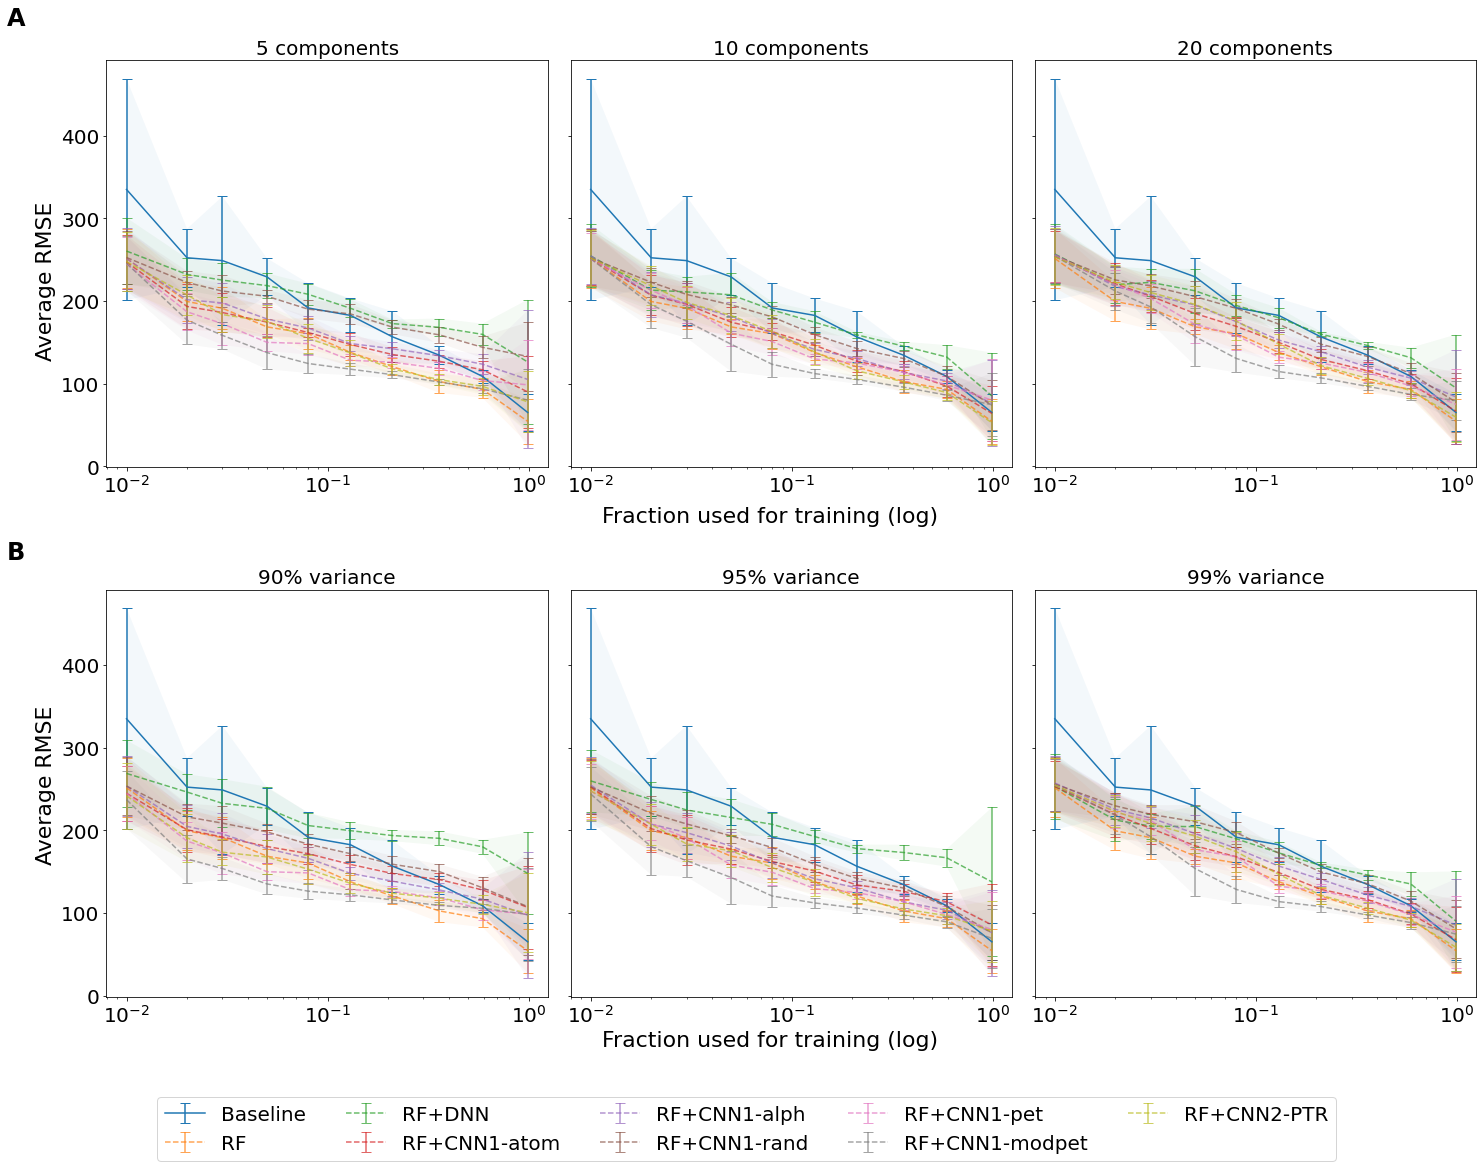

In [23]:
fig,ax  = plt.subplots(2,3,figsize= (20,14), sharex = False ,sharey = True)
ax = ax.ravel()
methods = ['Baseline','RF','RF+DNN','RF+CNN1-atom','RF+CNN1-alph','RF+CNN1-rand','RF+CNN1-pet','RF+CNN1-modpet','RF+CNN2-PTR']
ind = 0
for key in results_dict.keys():
    temp_dict = results_dict[key]
    for j,c in enumerate(temp_dict.keys()):
        method_dict = temp_dict[c]
        for k,method in enumerate(method_dict.keys()):
            random_subsampling_dict = method_dict[method]
            mean_list = []
            std_list = []
            for i in random_subsampling_dict.keys():
                mean = np.mean(random_subsampling_dict[i]['rmse'])
                std = np.std(random_subsampling_dict[i]['rmse'])
                mean_list.append(mean)
                std_list.append(std)
            mean_list = np.array(mean_list)
            std_list = np.array(std_list)
            if method != 'baseline':
                style = '--'
                alpha = 0.7
            else:
                style = '-'
                alpha = 1
            if key == 'fixed_inds':
                title = f'{c} components'
            else:
                title = f'{int(float(c)*100)}% variance'
            X = [float(x) for x in random_subsampling_dict.keys()]
            ax[ind].errorbar(X,mean_list,yerr = std_list,capsize=5,label = methods[k], linestyle = style, alpha = alpha)
            ax[ind].fill_between(X, mean_list-std_list, mean_list+std_list, alpha = 0.05, antialiased=True)
            ax[ind].set_xscale('log')
            #ax[ind].set_ylim(0,1)
            ax[ind].set_title(title, fontsize = 20)
            ax[ind].tick_params(axis='both', which='major', labelsize=20)

        ind += 1

fig.text(-0.01, 0.75, 'Average RMSE', va='center', rotation='vertical', fontsize = 22)
fig.text(-0.01, 0.25, 'Average RMSE', va='center', rotation='vertical', fontsize = 22)
fig.text(-0.03, 1.01, 'A', va='center', size=24, weight='bold')
fig.text(-0.03, 0.48, 'B', va='center', size=24, weight='bold')
fig.text(0.5, -0.01, 'Fraction used for training (log)', ha='center', fontsize = 22)
fig.text(0.5, 0.51, 'Fraction used for training (log)', ha='center', fontsize = 22)
plt.tight_layout()
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, fontsize = 20, ncol = 5, bbox_to_anchor = (-0.1, -0.05, 1, 0))
fig.subplots_adjust(hspace=0.3)
plt.savefig('figures/hea_hardness_general_combined.pdf',bbox_inches="tight")

### HEA Yield Strength

In [24]:
results_loc = 'results/hea_ys_general'
with open(os.path.join(results_loc,'random_subsampling_hea_ys.json'),'r') as fid:
    results_dict = json.load(fid)

ind_dict = results_dict['fixed_inds']
var_dict = results_dict['fixed_var']

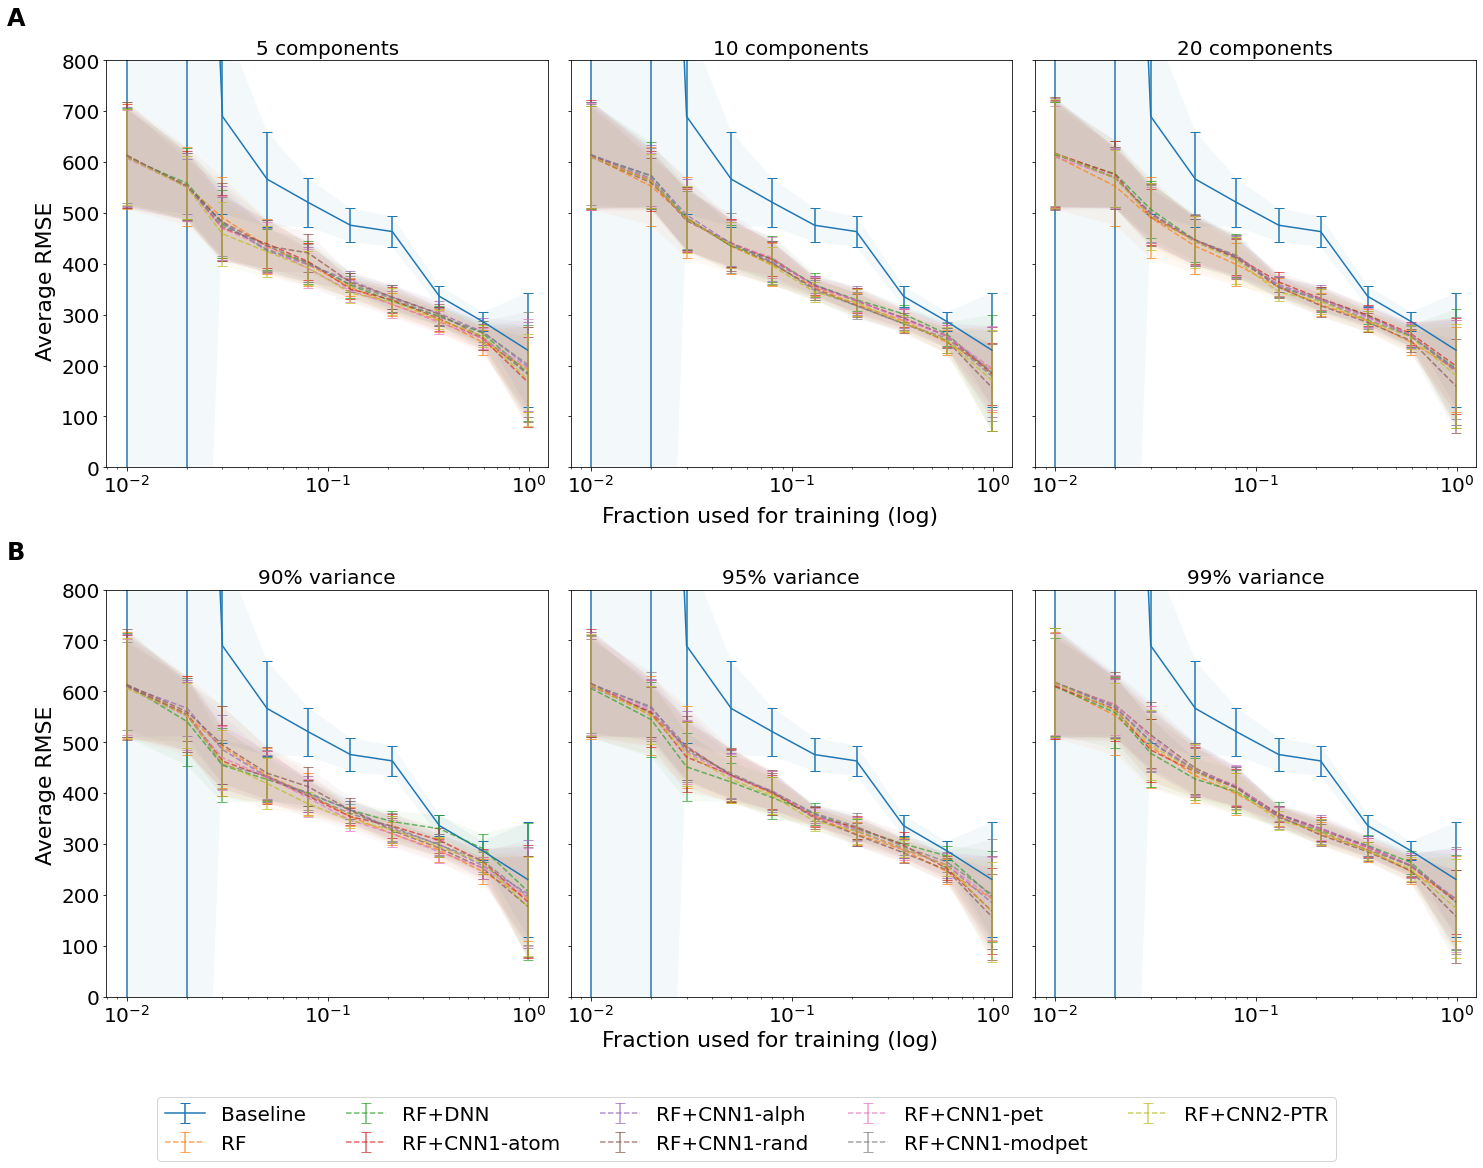

In [25]:
fig,ax  = plt.subplots(2,3,figsize= (20,14), sharex = False ,sharey = True)
ax = ax.ravel()
methods = ['Baseline','RF','RF+DNN','RF+CNN1-atom','RF+CNN1-alph','RF+CNN1-rand','RF+CNN1-pet','RF+CNN1-modpet','RF+CNN2-PTR']
ind = 0
for key in results_dict.keys():
    temp_dict = results_dict[key]
    for j,c in enumerate(temp_dict.keys()):
        method_dict = temp_dict[c]
        for k,method in enumerate(method_dict.keys()):
            random_subsampling_dict = method_dict[method]
            mean_list = []
            std_list = []
            for i in random_subsampling_dict.keys():
                mean = np.mean(random_subsampling_dict[i]['rmse'])
                std = np.std(random_subsampling_dict[i]['rmse'])
                mean_list.append(mean)
                std_list.append(std)
            mean_list = np.array(mean_list)
            std_list = np.array(std_list)
            if method != 'baseline':
                style = '--'
                alpha = 0.7
            else:
                style = '-'
                alpha = 1
            if key == 'fixed_inds':
                title = f'{c} components'
            else:
                title = f'{int(float(c)*100)}% variance'
            X = [float(x) for x in random_subsampling_dict.keys()]
            ax[ind].errorbar(X,mean_list,yerr = std_list,capsize=5,label = methods[k], linestyle = style, alpha = alpha)
            ax[ind].fill_between(X, mean_list-std_list, mean_list+std_list, alpha = 0.05, antialiased=True)
            ax[ind].set_xscale('log')
            ax[ind].set_ylim(0,800)
            ax[ind].set_title(title, fontsize = 20)
            ax[ind].tick_params(axis='both', which='major', labelsize=20)

        ind += 1

fig.text(-0.01, 0.75, 'Average RMSE', va='center', rotation='vertical', fontsize = 22)
fig.text(-0.01, 0.25, 'Average RMSE', va='center', rotation='vertical', fontsize = 22)
fig.text(-0.03, 1.01, 'A', va='center', size=24, weight='bold')
fig.text(-0.03, 0.48, 'B', va='center', size=24, weight='bold')
fig.text(0.5, -0.01, 'Fraction used for training (log)', ha='center', fontsize = 22)
fig.text(0.5, 0.51, 'Fraction used for training (log)', ha='center', fontsize = 22)
plt.tight_layout()
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, fontsize = 20, ncol = 5, bbox_to_anchor = (-0.1, -0.05, 1, 0))
fig.subplots_adjust(hspace=0.3)
plt.savefig('figures/hea_ys_general_combined.pdf',bbox_inches="tight")

## Variance

### phase dataset

In [26]:
from modules.function import data_generator_vec
[x0,dataY]=pickle.load(open(phase_file_path, 'rb'))
comps = [y.split(' ')[1] for y in x0]
comps_dset = data_generator_vec(pymatgen_comp(comps))

mean_comp = ''.join(list(phase_elem_count.keys()))
mean_comp_dset = data_generator_vec(pymatgen_comp([mean_comp]))
avg_variance = (((comps_dset.real_data - mean_comp_dset.real_data)**2).sum(axis=1)).sum()/len(comps)
avg_variance

0.22358379095373018

### hardness dataset

In [27]:
comps = hardness_df['Composition']
comps_dset = data_generator_vec(pymatgen_comp(comps))
mean_comp = ''.join(list(comps_dset.elements))
mean_comp_dset = data_generator_vec(pymatgen_comp([mean_comp]))
avg_variance = (((comps_dset.real_data - mean_comp_dset.real_data)**2).sum(axis=1)).sum()/len(comps)
avg_variance

0.11939838512523754

### Yield strength dataset

In [28]:
comps = yield_str_df['Composition']
comps_dset = data_generator_vec(pymatgen_comp(comps))
mean_comp = ''.join(list(comps_dset.elements))
mean_comp_dset = data_generator_vec(pymatgen_comp([mean_comp]))
avg_variance = (((comps_dset.real_data - mean_comp_dset.real_data)**2).sum(axis=1)).sum()/len(comps)
avg_variance

0.11564760400144845